In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
from src.AmortizedMixture import *
from src.models.NormalMixture import *


import matplotlib.pyplot as plt

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
model = NormalMixture(n_cls=2, n_obs=[100, 250], n_rep=[1,10], separation=5.0)

In [3]:
local_summary_net = bf.networks.DeepSet(summary_dim=2)
#global_summary_net = bf.networks.DeepSet(summary_dim=model.n_par*2, num_dense_s1=4, num_dense_s2=4, num_dense_s3=4)
global_summary_net = bf.networks.SetTransformer(input_dim=1, summary_dim=model.n_par*2)
amortized_posterior=bf.amortizers.AmortizedPosterior(
            inference_net=bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=10, coupling_design="spline"), 
            summary_net=bf.networks.HierarchicalNetwork([local_summary_net, global_summary_net]),
            summary_loss_fun="MMD"
        )

In [4]:
trainer = bf.trainers.Trainer(amortizer=amortized_posterior, generative_model=model, checkpoint_path="checkpoints/posterior", configurator=lambda x: x)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [5]:
%time
h = trainer.train_online(epochs=50, iterations_per_epoch=1000, batch_size=32)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


Training epoch 50: 100%|██████████| 1000/1000 [02:33<00:00,  6.52it/s, Epoch: 50, Iter: 1000,Loss: -3.597,W.Decay: 0.043,Avg.Loss: -3.382,Avg.W.Decay: 0.043,LR: 0.00E+00]


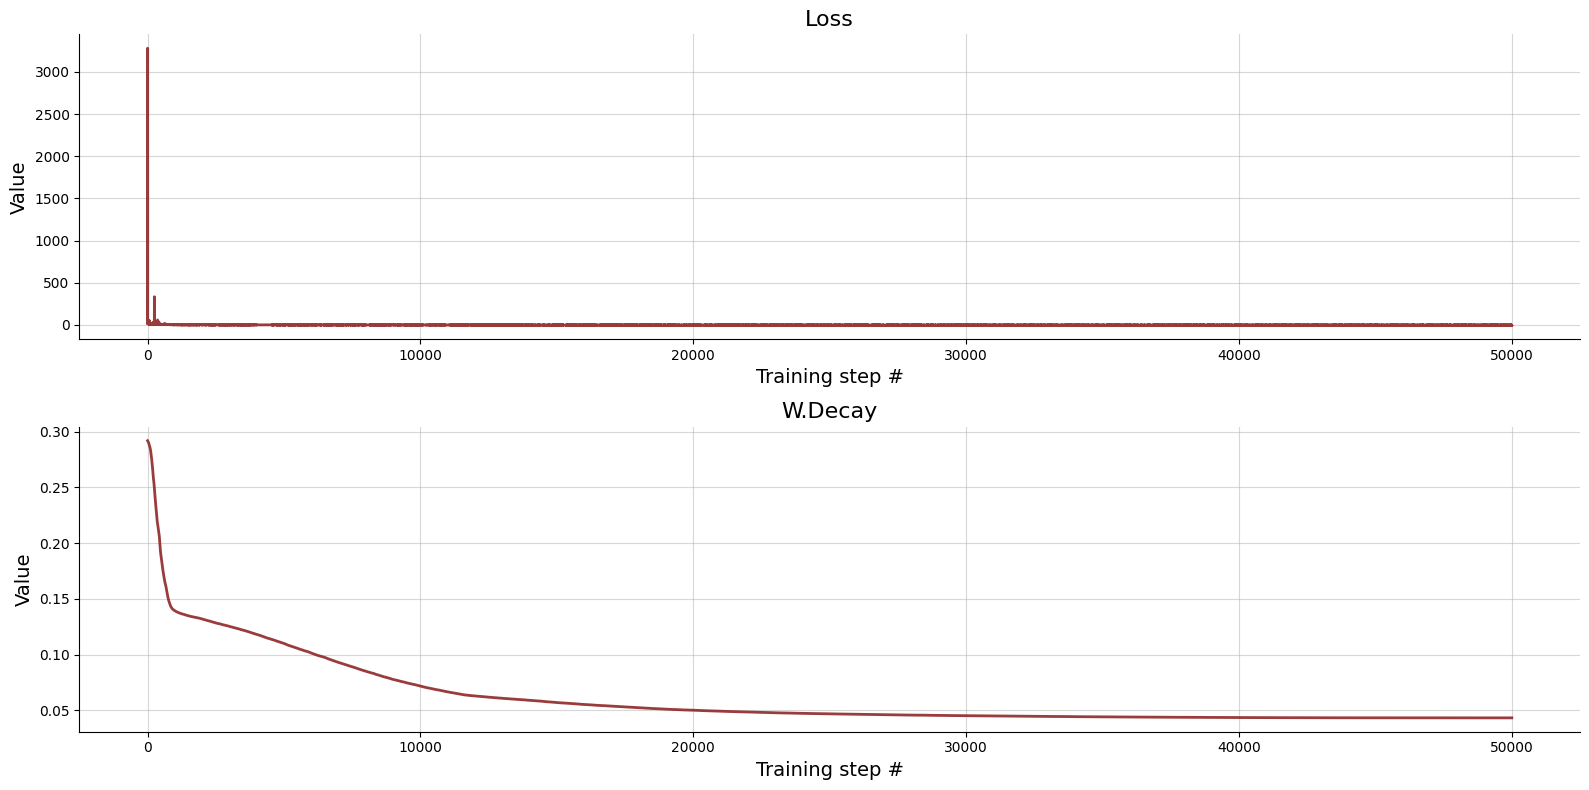

In [6]:
f=bf.diagnostics.plot_losses(h)

In [25]:
df = model(1000, context = {'n_obs': 200, 'n_rep': 1})
df['direct_conditions']

array([[200.,   1.],
       [200.,   1.],
       [200.,   1.],
       ...,
       [200.,   1.],
       [200.,   1.],
       [200.,   1.]], dtype=float32)

In [26]:
z, _ = trainer.amortizer(df)

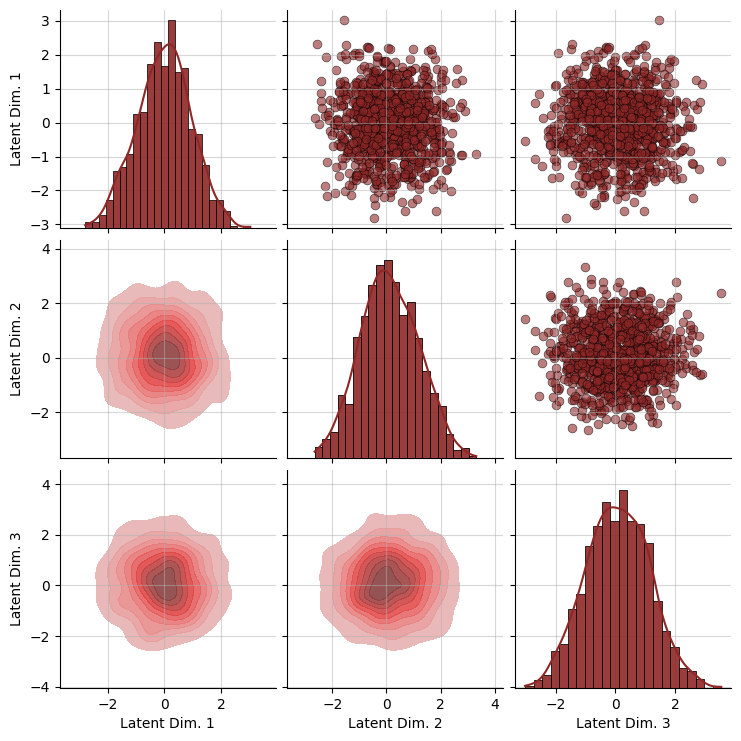

In [28]:
f = bf.diagnostics.plot_latent_space_2d(z)

In [29]:
posterior_samples = trainer.amortizer.sample(df, n_samples=1000)

In [30]:
prior_samples = df['parameters']

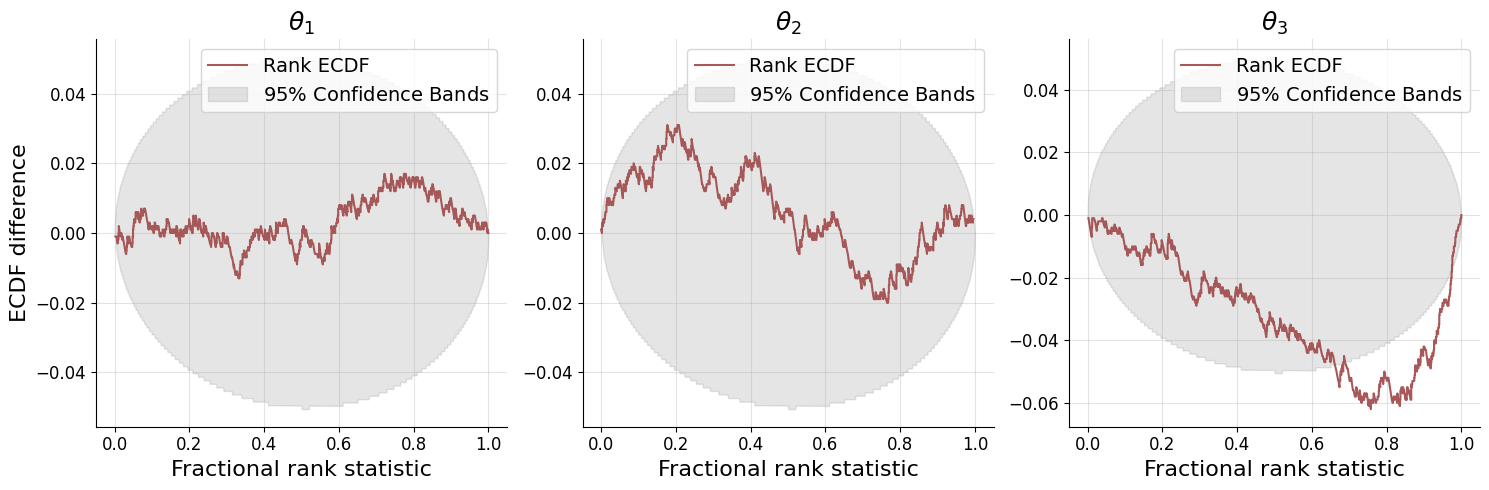

In [31]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, difference=True)

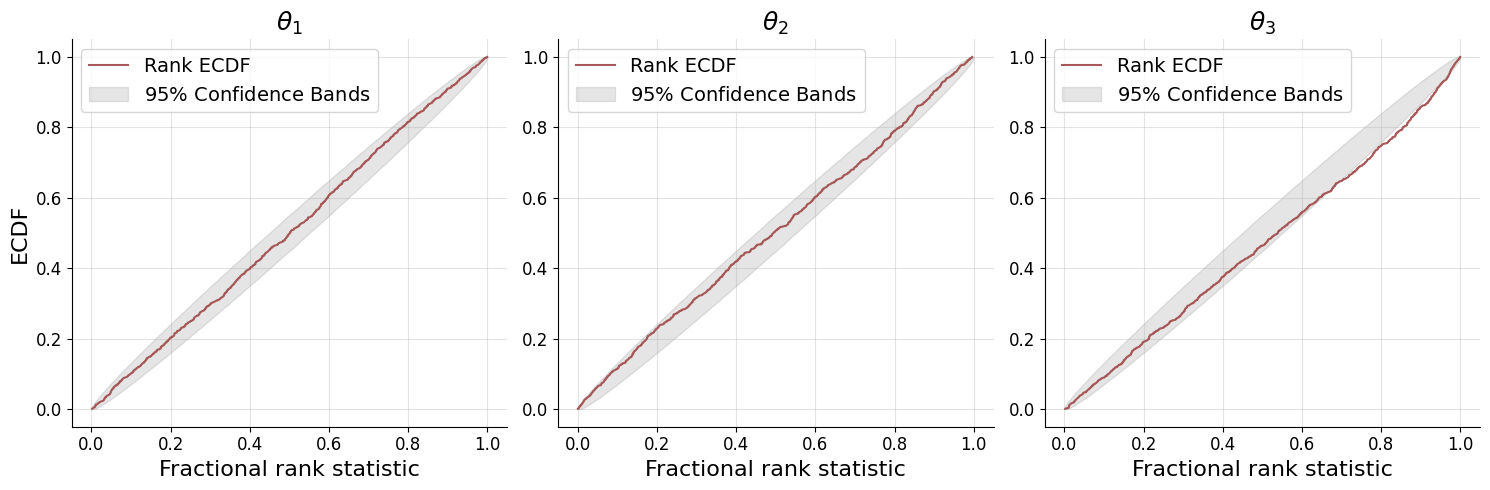

In [32]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples)

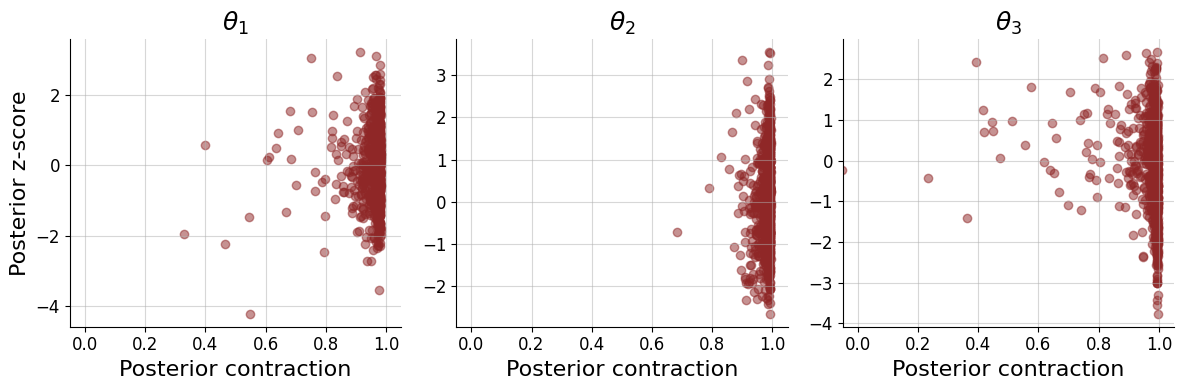

In [33]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_samples)

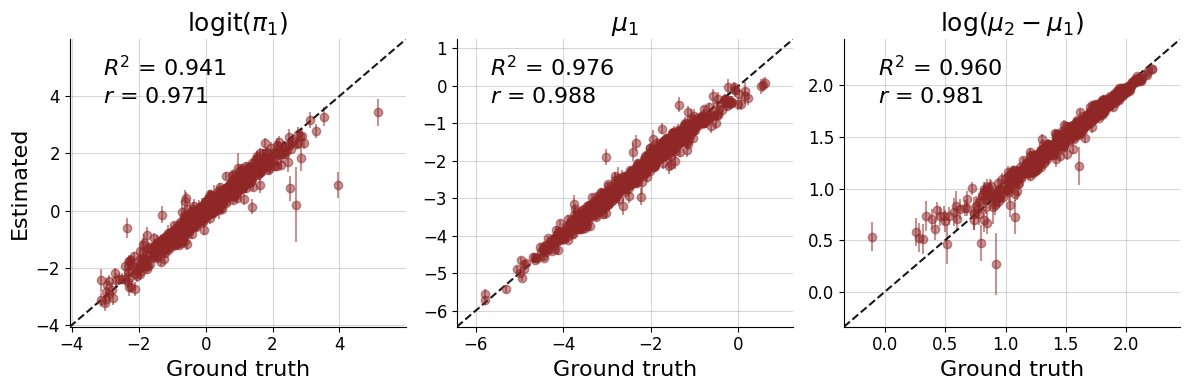

In [34]:
f = bf.diagnostics.plot_recovery(posterior_samples, prior_samples, param_names=[r"$\text{logit}(\pi_1)$", r"$\mu_1$", r"$\log(\mu_2 - \mu_1)$"])

## Constrained parameters

In [35]:
prior_samples_cons = model.extract_pars(prior_samples, axis=1)
post_samples_cons = model.extract_pars(posterior_samples, axis=2)

### Mixture proportions

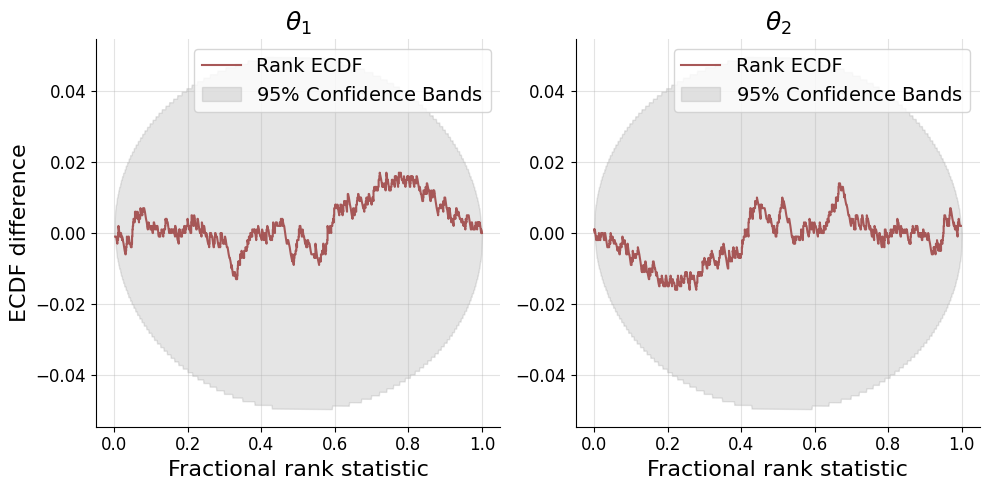

In [36]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['p'], prior_samples_cons['p'], difference=True)

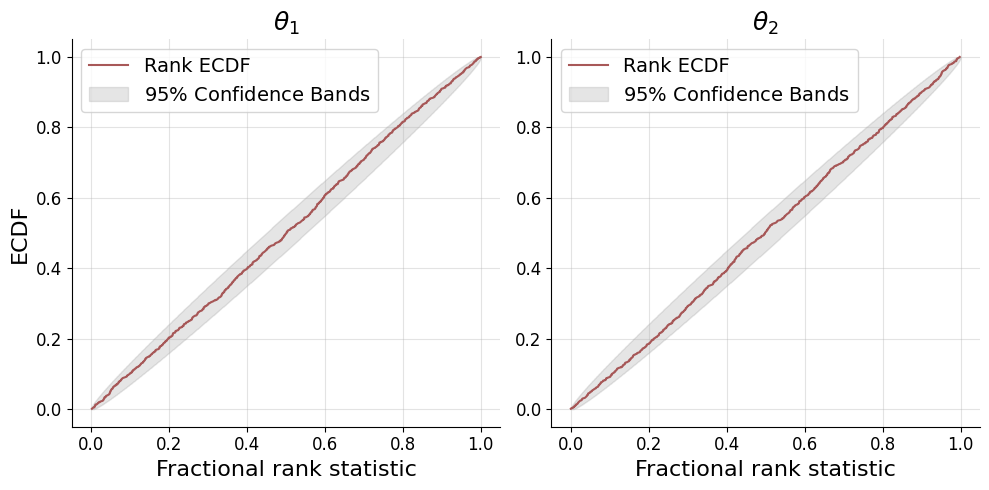

In [37]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['p'], prior_samples_cons['p'])

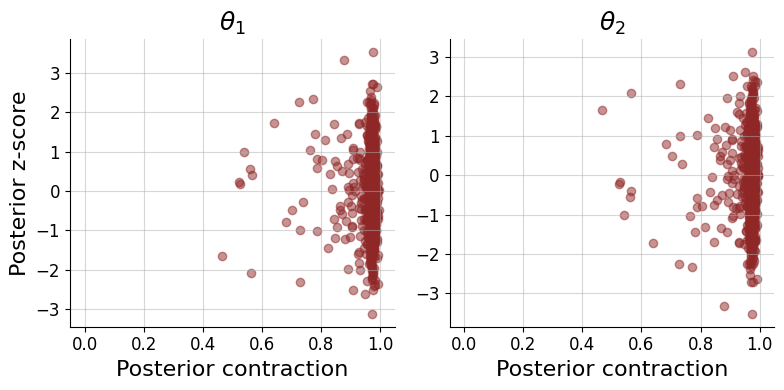

In [38]:
f = bf.diagnostics.plot_z_score_contraction(post_samples_cons['p'], prior_samples_cons['p'])

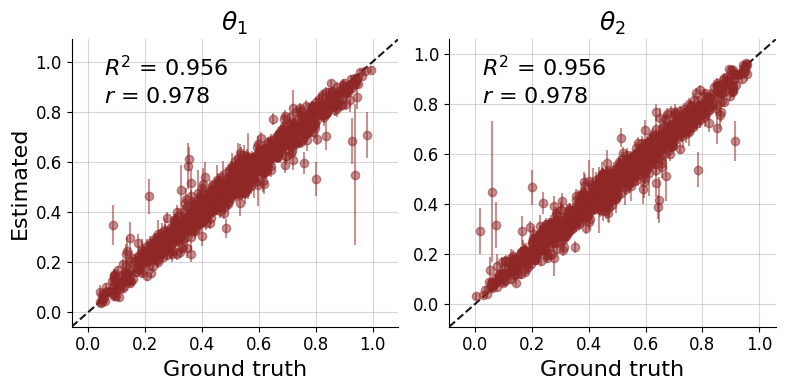

In [39]:
f = bf.diagnostics.plot_recovery(post_samples_cons['p'], prior_samples_cons['p'])

#### Mixture means

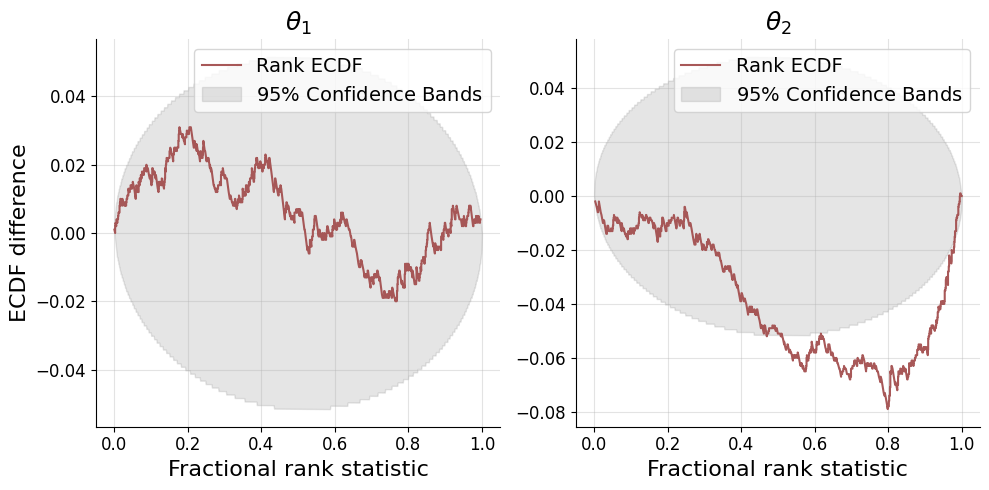

In [40]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['mu'], prior_samples_cons['mu'], difference=True)

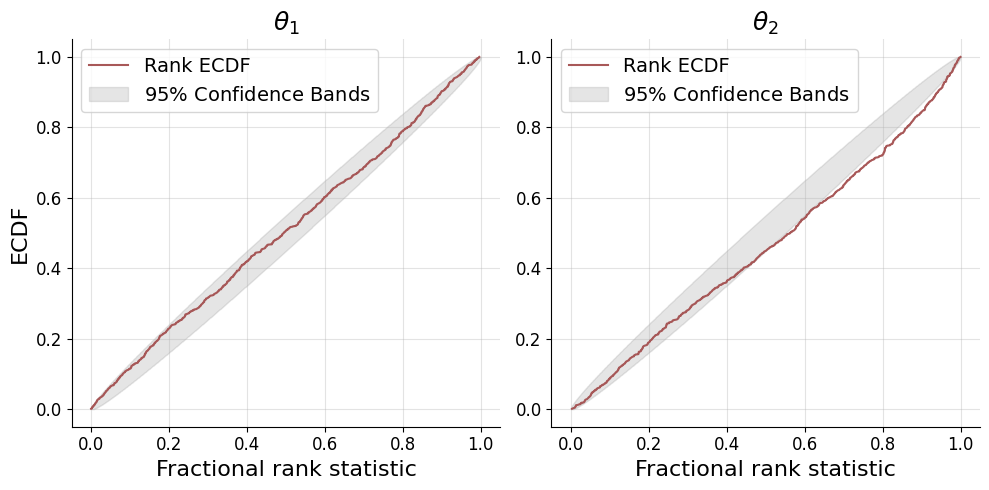

In [41]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['mu'], prior_samples_cons['mu'])

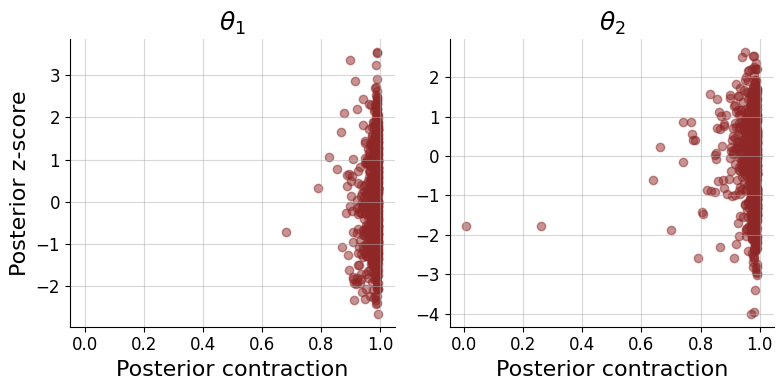

In [42]:
f = bf.diagnostics.plot_z_score_contraction(post_samples_cons['mu'], prior_samples_cons['mu'])

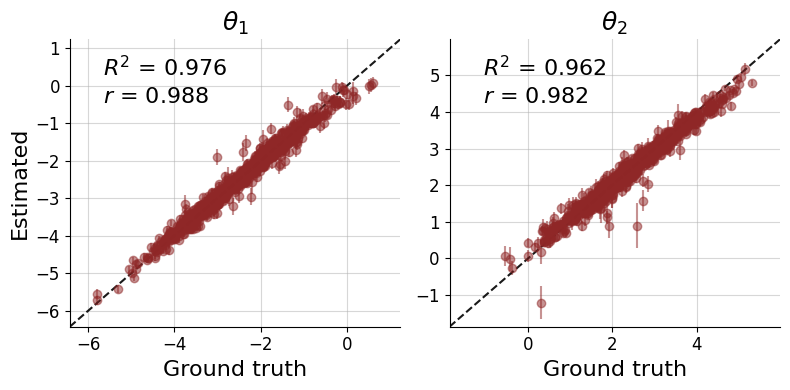

In [43]:
f = bf.diagnostics.plot_recovery(post_samples_cons['mu'], prior_samples_cons['mu'])